# Predictive Asthma Modeling

The objective of this workbook is to: 

- Collect and clean three datasets (asthma prevalence, social vulnerability indices, and air quality metrics). 

- Perform exploratory data analytics (EDA).

- Unsupervised modeling for feature engineering and data dimension reduction. 

- Supervised modeling for predicted asthma prevalence by census tract using the clustered features from the unsupervised model.

- Visualizations of final output and model. 

### Necessary Installs and Import Libraries

Uncomment the following block if networkx is not already installed in the environment.

In [154]:
#!pip install networkx==3.4.2

In [172]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from networkx.algorithms.community import modularity

## Data Collection and Cleaning

### Load and Inspect Data

PLACES data: https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-Census-Tract-D/cwsq-ngmh/about_data

In [2]:
# Load API data
url = "https://data.cdc.gov/resource/cwsq-ngmh.json"  # CDC API URL
params = {
    "$limit": 1000000,  # Increase limit to load all data
    "year": "2022",
    "measure": "Current asthma among adults"
}
response = requests.get(url, params=params)
data = response.json()

# Convert to a pandas DataFrame
asthma_df = pd.DataFrame(data)

# Keep only the required columns
asthma_df = asthma_df[['stateabbr', 'statedesc', 'countyname', 'locationname', 'data_value']]
asthma_df.rename(columns={'data_value': 'asthma_prevalence'}, inplace=True)
asthma_df['asthma_prevalence'] = pd.to_numeric(asthma_df['asthma_prevalence'], errors='coerce') / 100

# Display the dataframe
asthma_df

,stateabbr,statedesc,countyname,locationname,asthma_prevalence
0,FL,Florida,Miami-Dade,12086009907,0.100
1,FL,Florida,Miami-Dade,12086003705,0.076
2,FL,Florida,Miami-Dade,12086011800,0.086
3,FL,Florida,Miami-Dade,12086012101,0.090
4,FL,Florida,Miami-Dade,12086007705,0.078
...,...,...,...,...,...
83517,FL,Florida,Marion,12083001208,0.101
83518,FL,Florida,Marion,12083001205,0.094
83519,FL,Florida,Manatee,12081002003,0.094
83520,FL,Florida,Leon,12073000303,0.124


States by region stripped from: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

In [3]:
region_df = pd.read_csv("Region.csv")
region_df

,StateAbbr,Region
0,AL,South
1,AZ,West
2,AR,South
3,CA,West
4,CO,West
5,CT,Northeast
6,DE,South
7,DC,South
8,FL,South
9,GA,South


SVI data: https://www.atsdr.cdc.gov/place-health/php/svi/svi-data-documentation-download.html

In [4]:
# Load the SVI dataset
data_file = 'SVI_2022_US.csv'
svi_df = pd.read_csv(data_file)

# Drop the first five columns, the seventh column, and the eighth column from svi_df
columns_to_drop = svi_df.columns[:5].tolist() + [svi_df.columns[6], svi_df.columns[7]]
svi_df = svi_df.drop(columns=columns_to_drop)

# Display the dataframe
svi_df

,FIPS,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,E_UNEMP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,1001020100,1865,368,733,114,700,114,402,184,19,...,2.4,3.4,0.0,2.0,0.0,2.0,5.5,4.2,0.0,2.0
1,1001020200,1861,396,680,97,544,101,239,144,51,...,0.0,2.0,0.0,2.0,0.0,2.0,7.3,6.3,0.4,0.9
2,1001020300,3492,593,1431,213,1305,227,773,335,33,...,0.3,0.5,0.0,1.1,0.0,1.1,4.2,5.2,0.0,1.1
3,1001020400,3987,411,1722,211,1666,219,514,235,17,...,0.6,0.6,0.2,0.3,0.0,0.9,2.9,2.6,0.0,0.9
4,1001020501,4121,709,1857,283,1783,304,412,196,14,...,2.4,4.1,0.0,0.9,0.0,0.9,1.0,1.3,0.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84115,56043000200,3028,182,1580,136,1367,136,483,170,31,...,0.6,0.8,0.3,0.5,0.0,1.2,2.0,1.5,0.1,0.1
84116,56043000301,2323,246,1128,102,948,128,485,198,5,...,0.0,1.6,0.3,0.5,0.0,1.6,2.6,2.5,0.8,1.0
84117,56043000302,2374,270,1148,108,1099,117,475,243,36,...,0.5,0.9,0.3,0.8,0.0,1.6,5.1,3.1,0.0,1.6
84118,56045951100,3275,171,1557,130,1373,136,823,348,73,...,0.0,0.1,1.1,1.6,0.0,1.1,13.0,8.0,0.2,0.4


EPA data for environmental factors: https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-PM2-5-Concentrations-2016/96sd-hxdt/data_preview

In [5]:
# Load the API data
url = "https://data.cdc.gov/resource/96sd-hxdt.json"
params = {
    "$limit": 1000000,  # Increase limit to load all data
    "date": "31DEC2020"
}
response = requests.get(url, params=params)
data = response.json()

# Convert to a pandas DataFrame
epa_df = pd.DataFrame(data)

# Drop the specified columns from epa_df
epa_df = epa_df.drop(columns=['year', 'date', 'statefips', 'countyfips', 'latitude', 'longitude'])

# Display the dataframe
epa_df

,ctfips,ds_pm_pred,ds_pm_stdd
0,1001020100,15.523,10.7042
1,1001020200,15.433,10.3854
2,1001020300,15.999,11.138
3,1001020400,15.515,10.5776
4,1001020501,15.875,11.0316
...,...,...,...
83771,56043000200,1.807,1.1694
83772,56043000301,2.355,1.5672
83773,56043000302,2.326,1.4547
83774,56045951100,2.058,1.4051


### Combine and Clean the Datasets

In [6]:
# Combine the region with the asthma_df
asthma_df = asthma_df.merge(region_df, left_on='stateabbr', right_on='StateAbbr', how='left')

# Drop the duplicate column 'StateAbbr'
asthma_df = asthma_df.drop(columns=['StateAbbr'])

# Reorder the columns to ensure 'Region' is the first column
columns_order = ['Region'] + [col for col in asthma_df.columns if col != 'Region']
asthma_df = asthma_df[columns_order]

# Combine asthma_df, svi_df, and epa_df on the census tract FIPS code
# Ensure the data types of the columns being merged on match
asthma_df['locationname'] = asthma_df['locationname'].astype(str)
svi_df['FIPS'] = svi_df['FIPS'].astype(str)

# Merge the asthma and svi datasets
combined_df = asthma_df.merge(svi_df, left_on='locationname', right_on='FIPS', how='inner')

# Ensure the data types of columns being merged on match for the epa dataset
epa_df['ctfips'] = epa_df['ctfips'].astype(str)

# Merge combined_df (asthma + svi) with epa_df on asthma_df.locationname = svi_df.FIPS = epa_df.ctfips
final_combined_df = combined_df.merge(epa_df, left_on='locationname', right_on='ctfips', how='inner')
final_combined_df = final_combined_df.drop(columns=['ctfips', 'locationname'])
columns_order = ['FIPS'] + [col for col in final_combined_df.columns if col != 'FIPS']
asthma_df = final_combined_df[columns_order]

# Removing any rows with no population, and any rows with negative values 
final_combined_df = final_combined_df[
    (final_combined_df['E_TOTPOP']>0) & ~(final_combined_df==-999).any(axis=1)
].reset_index(drop=True)

# Display the final combined dataframe
final_combined_df

,Region,stateabbr,statedesc,countyname,asthma_prevalence,FIPS,E_TOTPOP,M_TOTPOP,E_HU,M_HU,...,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,ds_pm_pred,ds_pm_stdd
0,South,FL,Florida,Miami-Dade,0.100,12086009907,4120,971,1188,194,...,0.0,1.2,0.0,1.2,1.2,1.9,0.8,1.2,8.015,3.1296
1,South,FL,Florida,Miami-Dade,0.076,12086003705,1746,289,1399,93,...,0.0,2.8,0.0,2.8,14.2,6.2,1.0,1.7,6.203,2.5102
2,South,FL,Florida,Miami-Dade,0.086,12086011800,3521,734,1110,171,...,0.0,1.4,0.0,1.4,0.2,0.5,1.6,1.9,7.986,3.3325
3,South,FL,Florida,Miami-Dade,0.090,12086012101,2987,875,1271,386,...,0.0,1.7,0.0,1.7,0.0,1.7,0.0,1.7,7.913,3.273
4,South,FL,Florida,Miami-Dade,0.078,12086007705,5120,582,2515,248,...,0.0,1.0,0.0,1.0,0.9,1.2,0.4,0.6,6.455,2.9832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67363,South,FL,Florida,Marion,0.101,12083001208,3891,679,1863,168,...,0.0,1.3,0.0,1.3,0.6,0.8,0.0,1.3,9.504,5.3214
67364,South,FL,Florida,Marion,0.094,12083001205,4279,450,2211,184,...,0.0,1.2,0.0,1.2,2.2,1.9,0.0,1.2,9.424,5.231
67365,South,FL,Florida,Manatee,0.094,12081002003,6144,1230,3379,407,...,0.0,0.8,0.0,0.8,4.7,2.9,0.0,0.8,9.398,4.2423
67366,South,FL,Florida,Leon,0.124,12073000303,5030,968,2097,232,...,0.0,1.0,0.0,1.0,2.1,1.8,0.5,0.8,10.991,7.7057


## Exploratory Data Analysis

In [7]:
# Checking for missing values
missing_values = final_combined_df.isnull().sum()

# Display the missing values
print(missing_values)

Region               0
stateabbr            0
statedesc            0
countyname           0
asthma_prevalence    0
                    ..
MP_TWOMORE           0
EP_OTHERRACE         0
MP_OTHERRACE         0
ds_pm_pred           0
ds_pm_stdd           0
Length: 158, dtype: int64


There are no missing values, in the 158 columns of our dataset, signaling that there is no need for data imputation. 

In [8]:
# Shape of the dataset
print(final_combined_df.shape)

# Checking for duplicates
print( final_combined_df.duplicated().sum())

# Data types
print(final_combined_df.dtypes)
print(final_combined_df.select_dtypes('object').columns)
final_combined_df['ds_pm_pred'] = pd.to_numeric(final_combined_df['ds_pm_pred'], errors='coerce')
final_combined_df['ds_pm_stdd'] = pd.to_numeric(final_combined_df['ds_pm_stdd'], errors='coerce')

(67368, 158)
0
Region                object
stateabbr             object
statedesc             object
countyname            object
asthma_prevalence    float64
                      ...   
MP_TWOMORE           float64
EP_OTHERRACE         float64
MP_OTHERRACE         float64
ds_pm_pred            object
ds_pm_stdd            object
Length: 158, dtype: object
Index(['Region', 'stateabbr', 'statedesc', 'countyname', 'FIPS', 'ds_pm_pred',
       'ds_pm_stdd'],
      dtype='object')


Our dataset contains 67,368 rows and 158 columns. There are no duplicates and we converted the ds_pm_pred, ds_pm_stdd values to numerical formats, allowing them to be used for later learning algorithm stages. 

## Unsupervised Learning Algorithms

### Standardizing + PCA

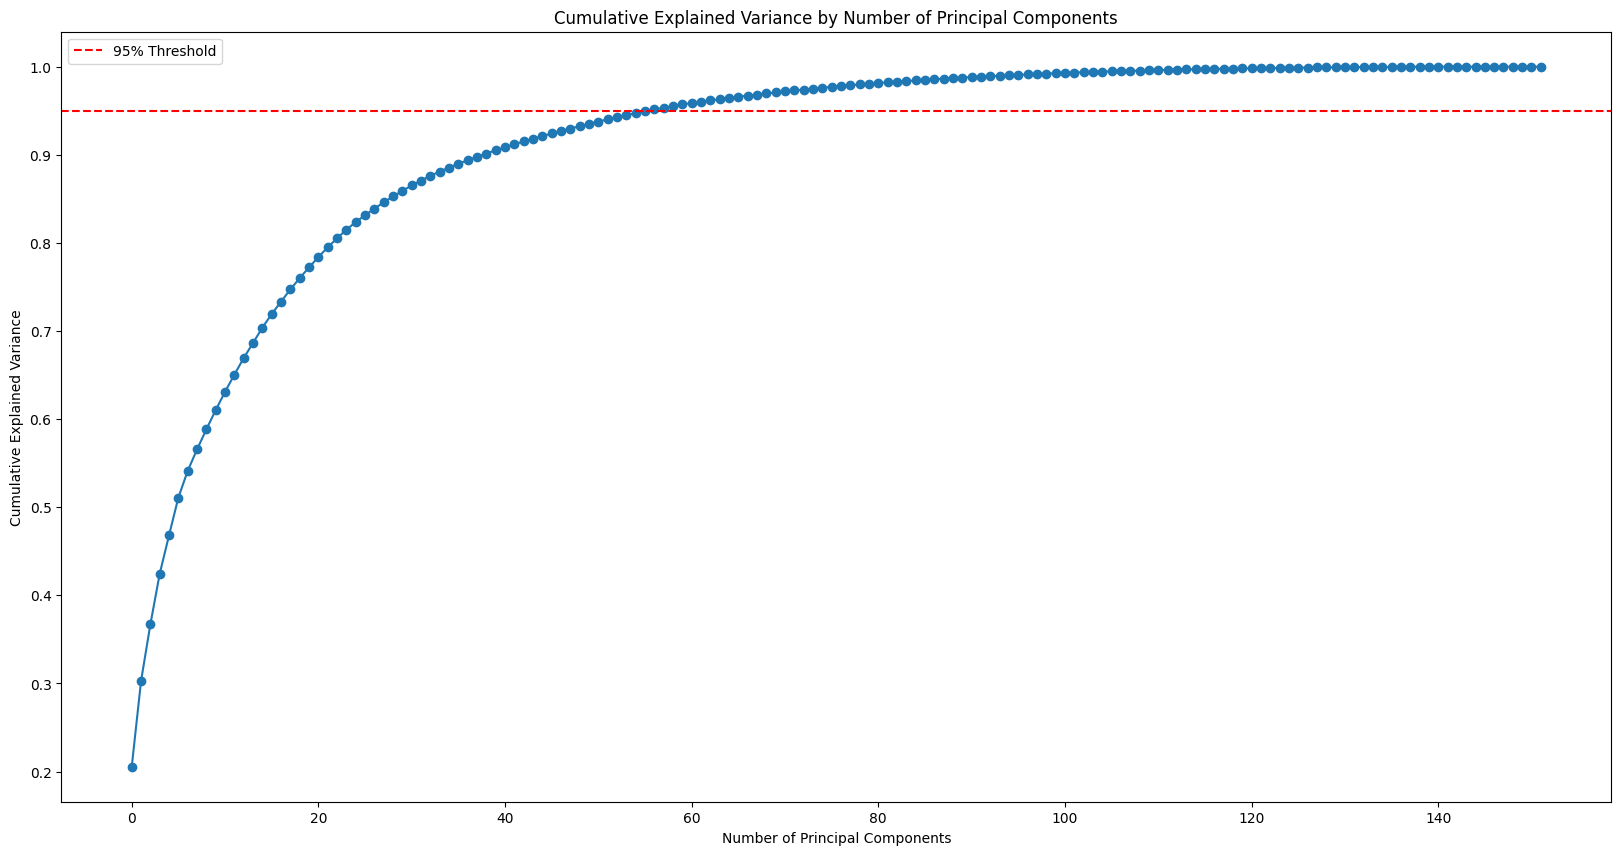

57


In [9]:
# Dropping any non-numeric columns + asthma_prevalence (since that's what we're trying to predict)
unsupervised_df = final_combined_df.drop(columns=['Region', 'stateabbr', 'statedesc', 'countyname', 'FIPS', 'asthma_prevalence'])

#Using Standard Scaler to standardize the dataset
scaler = StandardScaler()
scaled = scaler.fit_transform(unsupervised_df)

# Running PCA
pca = PCA()
x_pca = pca.fit_transform(scaled)

# Explained variance ratio
# Plotting the cumulative explained variance by number of principal components
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, label='95% Threshold', color='red', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.legend(loc='upper left')
plt.show()

# Keeping only the first n principal components that represent 95% of the variance
threshold = 0.95
cumulative = np.cumsum(pca.explained_variance_ratio_)
n = np.where(cumulative >= threshold)[0][0] + 1
print(n)
x_pca = x_pca[:,:n]

We first used standard scaler to normalize all features and set up our data for PCA. Then, we ran PCA to reduce dimensionality, and we've kept the top 57 components that represent 95% of the variance. 

### K-Means Clustering

In [99]:
# Running K-Means Clustering with different values of K and using Silhouette Score to find the optimal number of clusters
# This may take a few minutes to run
k = range(2,10)
scores = []
for i in k:
    # using random_state=42 for consistency
    kmeans = KMeans(n_clusters=i,random_state=42)
    res = kmeans.fit_predict(x_pca)
    score = silhouette_score(x_pca,res)
    scores.append(score)
    print(i,score)
best_silhouette = max(scores)

2 0.22712927357885085
3 0.10087836806705562
4 0.11367971192924088
5 0.0957503798725186
6 0.08243862703387249
7 0.08652506595245539
8 0.05799039982234971
9 0.06002464092413794


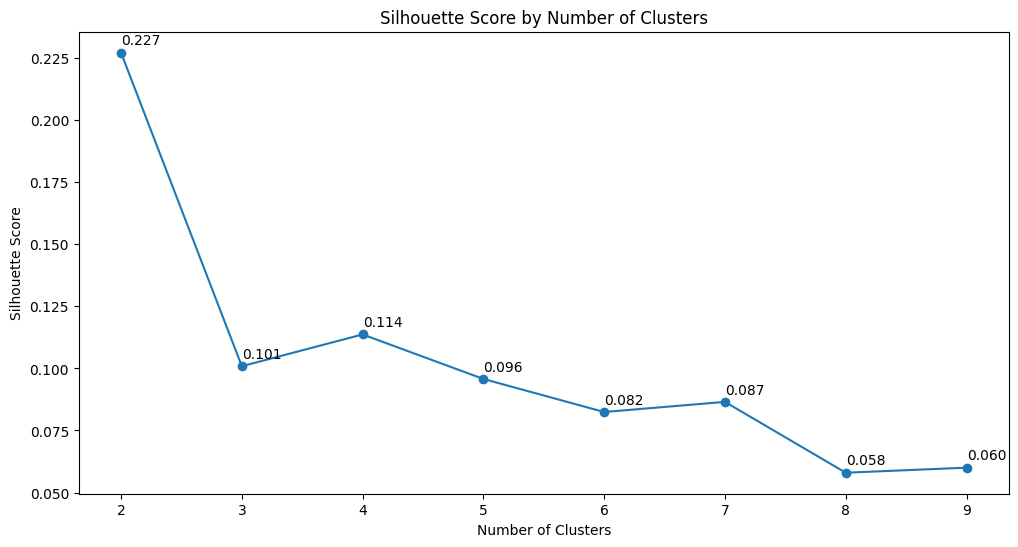

In [103]:
# Visualizing the Silhouette Scores
plt.figure(figsize=(12,6))
plt.plot(k,scores, 'o-')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
# Labeling the points
k = range(2,10)
for i,score in zip(k,scores):
    plt.text(i+0.001,score+0.0032, f"{score:.3f}")
plt.show()

Based off of silhouette scores, the ideal number of clusters is either 2 with a score of 0.227, or 4 with a score of 0.114.

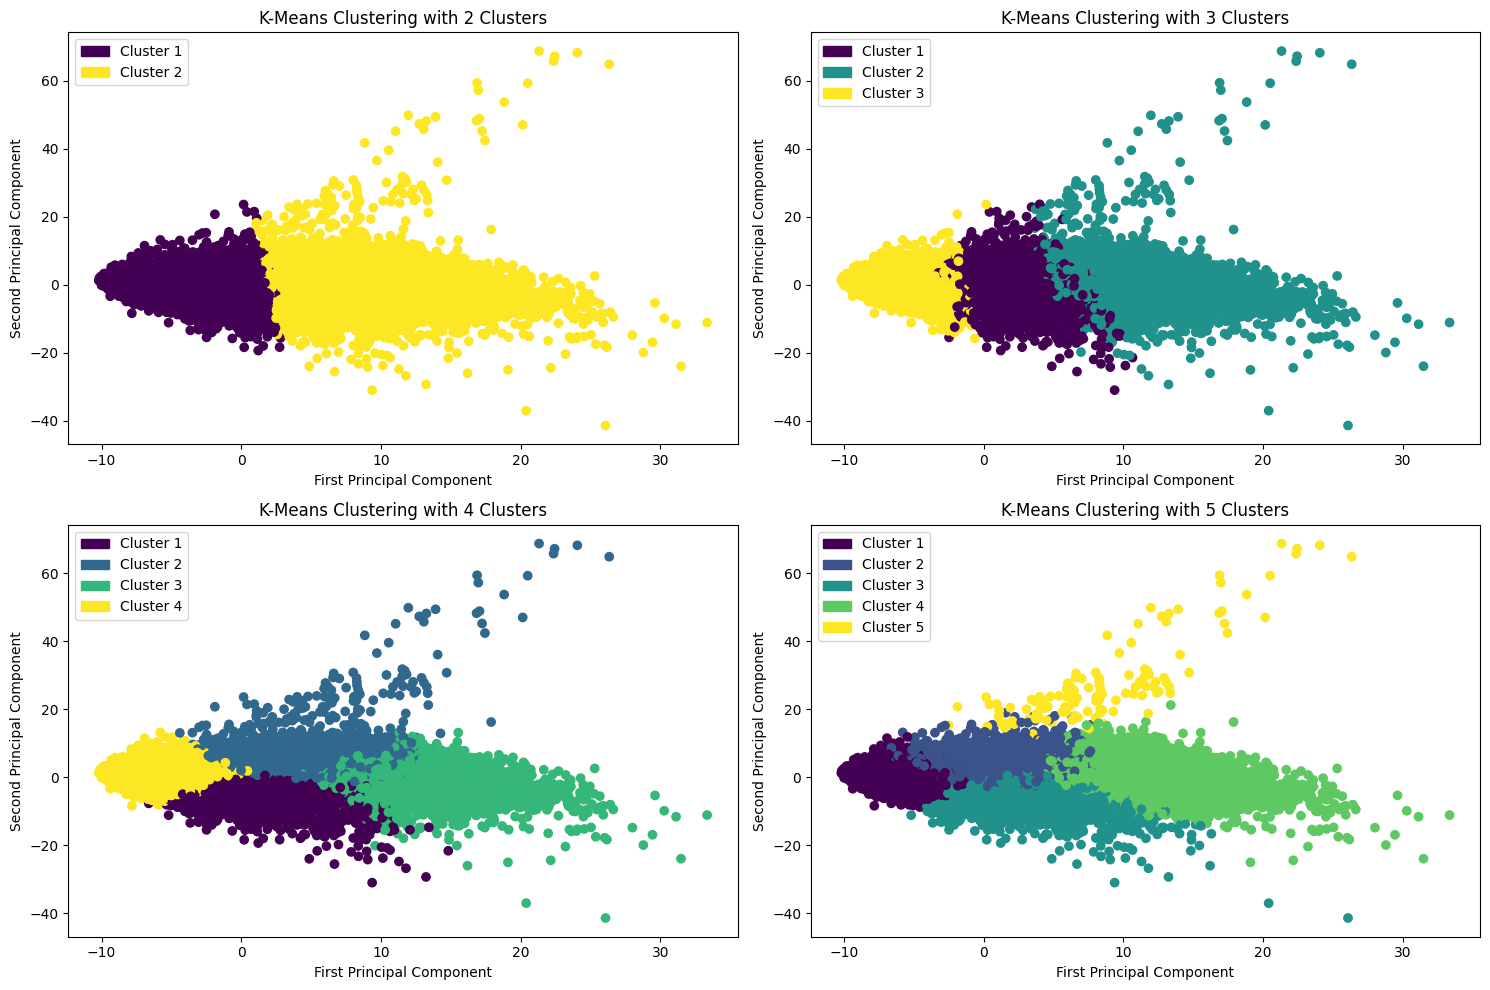

In [142]:
# Plotting the clusters in a 2D space (based on the first two PCA components)
plt.figure(figsize=(15,10))
for i,j in enumerate(range(2,6)):
    kmeans = KMeans(n_clusters=j, random_state=42)
    res = kmeans.fit_predict(x_pca)
    plt.subplot(2,2,i+1)
    plt.scatter(x_pca[:,0],x_pca[:,1], c=res)
    plt.title(f'K-Means Clustering with {j} Clusters')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    # Adding a legend for each cluster (i+1 to account for zero indexing)
    labels = [f'Cluster {i+1}' for i in range(j)]
    colors = plt.cm.get_cmap('viridis', j)
    color_labels =[matplotlib.patches.Patch(color=colors(i),label=labels[i]) for i in range(j)]
    plt.legend(handles=color_labels, loc='upper left')
plt.tight_layout()
plt.show()

Looking at these visuals, we can see that choosing 4 clusters provides the best balance between capturing complexity and having adequate separation between the clusters. Despite the silhouette score being a bit lower, the 4 cluster solution will allow us to discover deeper patterns that would be missed with a 2 way split. 

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,15898.0,0.102831,0.012744,0.057,0.094,0.102,0.111,0.156
1,14144.0,0.118509,0.015735,0.063,0.108,0.118,0.128,0.207
2,6581.0,0.108544,0.016419,0.061,0.096,0.106,0.119,0.182
3,30745.0,0.103087,0.011211,0.050,0.095,0.103,0.111,0.150


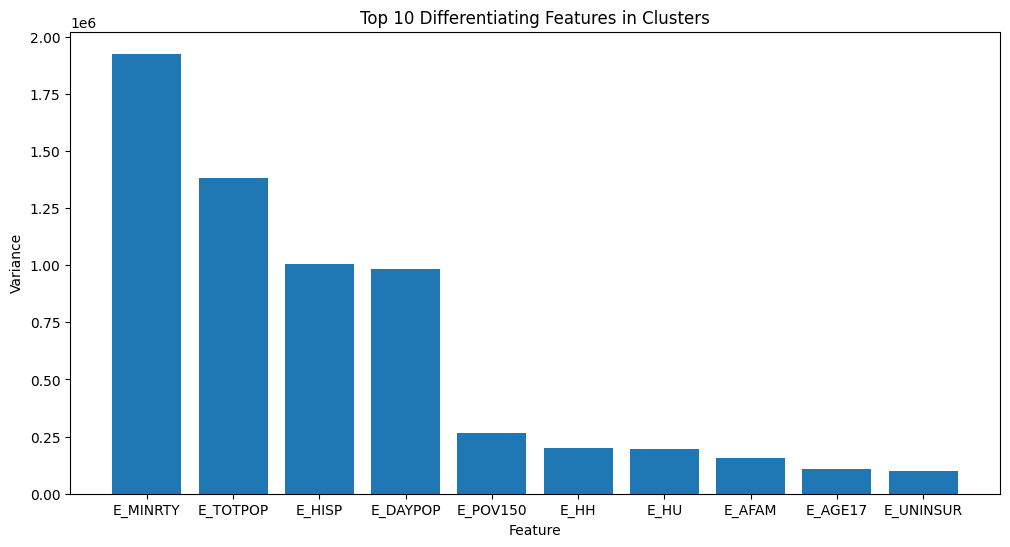

In [139]:
# Running the final k-means clustering with 4 clusters + adding the cluster labels to the original dataframe
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_result = kmeans.fit_predict(x_pca)
final_combined_df['Cluster'] = kmeans_result

# Getting the summary statistics of the clusters for asthma prevalence
clustering_asthma =final_combined_df.groupby('Cluster')['asthma_prevalence'].describe()
display(clustering_asthma)

# Looking at the top 10 most differing features for each cluster
# getting the means, then finding the ones with most variance between the 4 clusters
most_var = final_combined_df.groupby('Cluster').mean(numeric_only=True).var()
top10 = most_var.sort_values(ascending=False).head(10)
# Plotting the top 10 most differing features
plt.figure(figsize=(12,6))
plt.bar(top10.index, top10.values)
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.title('Top 10 Differentiating Features in Clusters')
plt.show()

From the table, we can see that the highest average asthma prevalence is in cluster 1 (11.85%), and the lowest prevalence is in cluster 0 (10.28%). To better understand how the 4 clusters differ, we visualized which features had the highest variance between clusters. The top two were E_MINRTY: Estimated Minority Population and E_TOTPOP: Estimated Total Population. This suggests the population and demographic composition are the key factors the separate the clusters.

### Community Detection

In [208]:
# Using Louvain Community Detection
# First finding the ideal parameters that give us the best modularity score (may take a bit to run)
num_neighbors = [10,11,12,15,20]
resolutions = [0.8,0.9,1]
results = []
for i in num_neighbors:
    # Making a graph using our PCA results
    matrix = kneighbors_graph(x_pca, i,include_self=False)
    graph = nx.from_scipy_sparse_array(matrix)
    for j in resolutions:
        #Running Louvain community detection (using seed to control randomness)
        comm = nx.community.louvain_communities(graph,seed=42, resolution=j)
        mod = modularity(graph,comm)
        results.append({'n': i, 'res':j,'mod':mod})
# Displaying the table to see the ideal parameters
best_comm_params = pd.DataFrame(results)
best_comm_params = best_comm_params.pivot(index='n',columns='res', values='mod')
display(best_comm_params)

res,0.8,0.9,1.0
n,,,
10,0.746576,0.746954,0.748160
11,0.739620,0.742975,0.744729
12,0.740189,0.743227,0.742283
15,0.734045,0.734631,0.734979
20,0.716588,0.719096,0.721468


We can see that the optimal parameters are to use 10 numbers of neighbors when creating the graph, and a resolution of 1.0 when running the Louvain communities algorithm.

In [205]:
# Running Louvain community detection with the best parameters we found (n=10, resolution=1.0)
matrix = kneighbors_graph(x_pca, 10,include_self=False)
graph = nx.from_scipy_sparse_array(matrix)
comm = nx.community.louvain_communities(graph, seed=42, resolution=1.0)
mod_score = modularity(graph,comm)
print(mod_score)

# Adding the community labels to the original dataframe
for i,j in enumerate(comm):
    for k in j:
        final_combined_df.loc[k,'Community'] = i

0.7481597865821419


The modularity score is 0.748. Let's visualize the communities in 2D using our PCA results. 

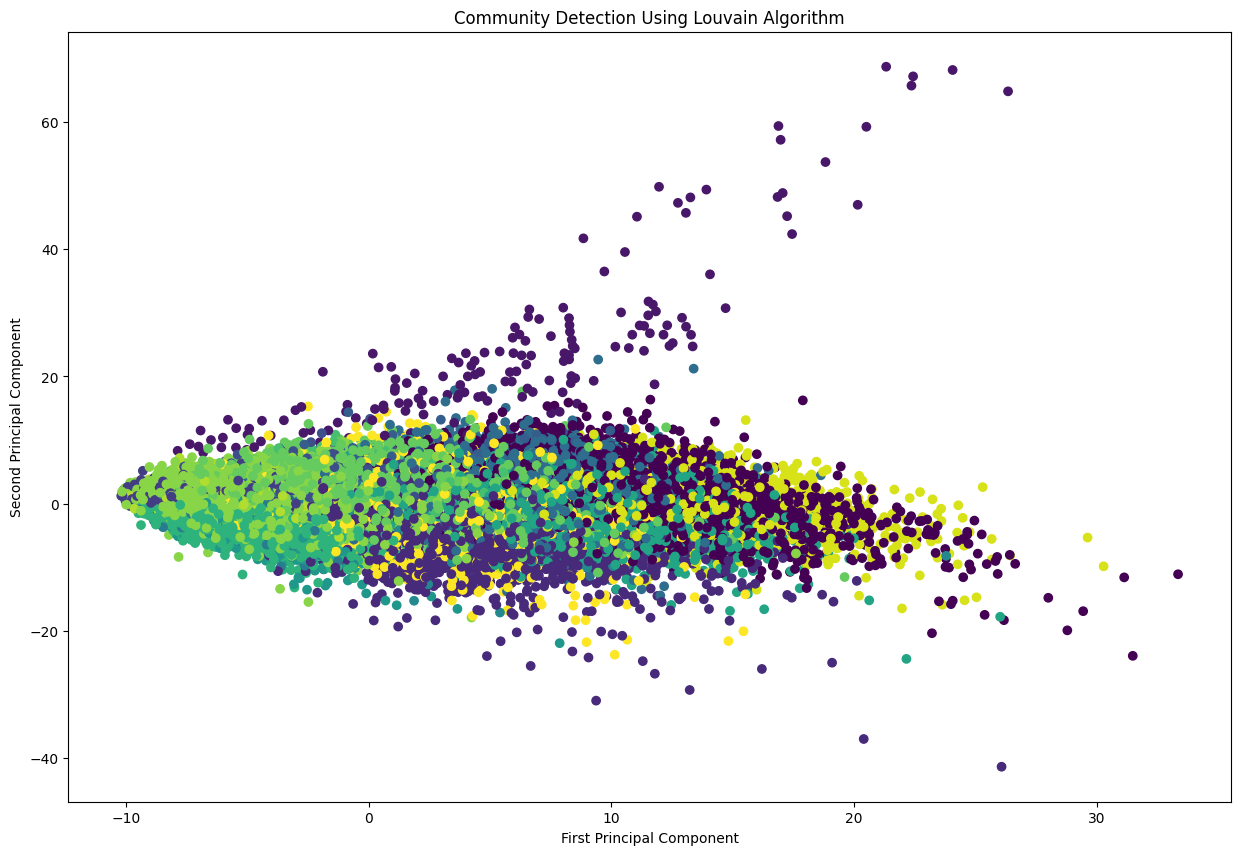

In [218]:
# Generating a plot using our PCA results for the communities
plt.figure(figsize=(15,10))
plt.scatter(x_pca[:,0],x_pca[:,1], c=final_combined_df['Community'])
plt.title('Community Detection Using Louvain Algorithm')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

This visual shows the communities within a 2D space using results from PCA. Unlike K-Means Clustering which relies on spacial distance, community detection algorithms (we used Louvain) creates communities based on graph connectivity. This is why some communities seem to be so intermixed when graphed on a 2D space, despite there being substantial differences between them. Let's look at a asthma prevalence between the different communities and again graph the top 10 most differing features.

,count,mean,std,min,25%,50%,75%,max
Community,,,,,,,,
0.0,3861.0,0.125978,0.016357,0.063,0.11400,0.1250,0.137,0.207
1.0,162.0,0.107438,0.022190,0.067,0.09000,0.1045,0.120,0.171
2.0,7620.0,0.106307,0.012683,0.066,0.09700,0.1050,0.115,0.164
3.0,2224.0,0.100638,0.009895,0.074,0.09400,0.1010,0.107,0.137
4.0,2336.0,0.106890,0.011167,0.074,0.09900,0.1060,0.114,0.148
5.0,981.0,0.125685,0.015339,0.085,0.11600,0.1250,0.134,0.189
6.0,4933.0,0.118827,0.014975,0.077,0.10800,0.1190,0.129,0.189
7.0,438.0,0.099932,0.011783,0.066,0.09225,0.1000,0.108,0.140
8.0,831.0,0.111782,0.011941,0.070,0.10400,0.1110,0.119,0.150


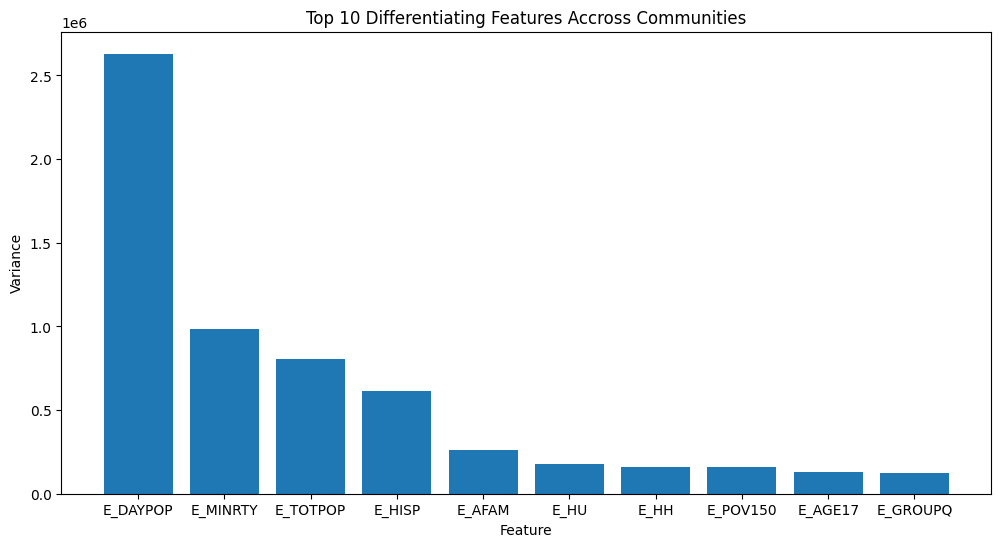

In [215]:
# Getting the summary statistics of the communities for asthma prevalence
comm_asthma =final_combined_df.groupby('Community')['asthma_prevalence'].describe()
display(comm_asthma)

# Looking at the top 10 most differing features for each communitity
# getting the means, then finding the ones with most variance
most_var_community = final_combined_df.groupby('Community').mean(numeric_only=True).var()
top10_comm = most_var_community.sort_values(ascending=False).head(10)
# Plotting the top 10 most differing features
plt.figure(figsize=(12,6))
plt.bar(top10_comm.index, top10_comm.values)
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.title('Top 10 Differentiating Features Accross Communities')
plt.show()

Community detection using the Louvain algorithm formed 18 communities. Community 0 had the highest average asthma prevalence (12.60%), while community 9 had the lowest asthma prevalence (9.81%). The top two differentiating features across the communities were E_DAYPOP: Estimated Daytime Population and E_MINRTY: Estimated Minority Population. This suggests the daytime population and demographic composition are the key factors the separate the communities.

## Supervised Learning Algorithms

## Visualizations

### Asthma Prevalence Distribution

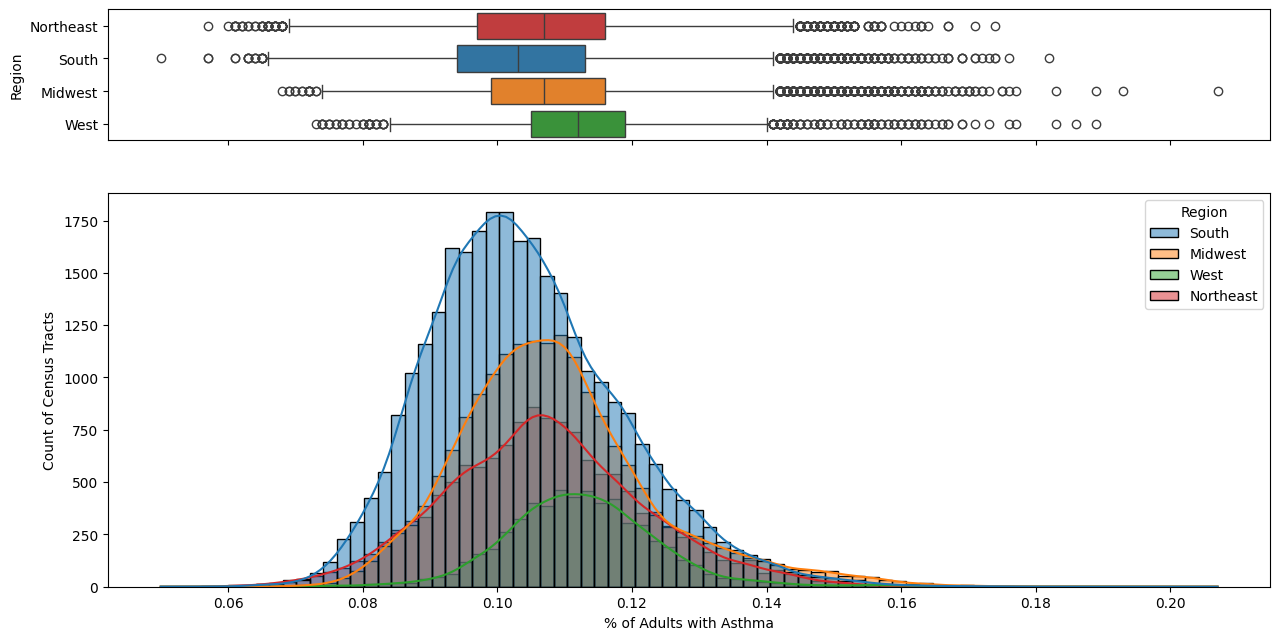

In [14]:
# Corrected code to show the distribution of asthma prevalence at the census tract-level by region
order_list = ['Northeast', 'South', 'Midwest', 'West']

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)}, figsize=(15,7.5))

# Histogram plot with seaborn
sns.histplot(data=final_combined_df, x="asthma_prevalence", hue="Region", kde=True, ax=ax_hist, binwidth=0.002)

# Boxplot for display
sns.boxplot(x="asthma_prevalence", y="Region", hue="Region", data=final_combined_df, ax=ax_box, order=order_list)

# Customizing patch colors and handles for the boxplot
for i, patch in enumerate(ax_box.artists):
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    for j in range(i * 6, i * 6 + 6):
        line = ax_box.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Adding labels
plt.xlabel('% of Adults with Asthma')
plt.ylabel('Count of Census Tracts')

# Show the plot
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2e4bb56e-bb11-472e-b004-75e9d3aa782e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>